# **Generating Flower Images - GAN**

In [1]:
import torch
from torch import FloatTensor, LongTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [12]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((100, 100)),
        transforms.Normalize(mean = (0.5), std = (0.5))
    ]
)

In [13]:
data = datasets.Flowers102(root = "data", download = True, transform = transform)

In [14]:
data_loader = DataLoader(data, batch_size = 50, shuffle = True)
data_loader.dataset

Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
               Normalize(mean=0.5, std=0.5)
           )

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

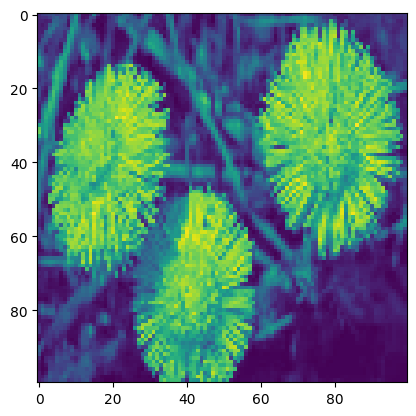

In [20]:
plt.imshow(data_loader.dataset[117][0][0])

In [21]:
import torch.nn as nn

In [37]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 2, padding = 0),
        nn.ReLU(),

        nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5, stride = 2, padding = 0 ),
        nn.ReLU(),

        nn.Flatten(),

        nn.Linear(12 * 22 * 22, 256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(256, 128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [23]:
latent_dim = 100

class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(128, 3 * 100 * 100),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [38]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [39]:
loss_fn = nn.BCELoss()

optim_g = torch.optim.Adam(generator.parameters(), lr = 0.001)
optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.001)

In [32]:
import os
from torchvision.utils import save_image

In [46]:
epochs = 50

for epoch in range(epochs):
  for b, (imgs, _) in enumerate(data_loader):
    if b == 20:
      continue

    imgs = imgs.to(device)

    real_labels = torch.ones(50, 1).to(device)
    fake_labels = torch.zeros(50, 1).to(device)

    # Training -> Generator
    x = torch.randn(50, 100).to(device)
    fake_imgs = generator(x).view(-1, 3, 100, 100)
    g_loss = loss_fn(discriminator(fake_imgs), real_labels)
    optim_g.zero_grad()
    g_loss.backward()
    optim_g.step()

    # Training -> Discriminator
    d_loss_real = loss_fn(discriminator(imgs), real_labels)
    d_loss_fake = loss_fn(discriminator(fake_imgs.detach()), fake_labels)
    d_loss = (d_loss_real + d_loss_fake) / 2
    optim_d.zero_grad()
    d_loss.backward()
    optim_d.step()

    if b % 10 == 0:
            print(f"[Epoch {epoch}] [Batch {b}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

  # Save generated images
  os.makedirs("image", exist_ok=True)
  save_image(fake_imgs.view(fake_imgs.size(0), 3, 100, 100), f"image/{epoch}.png", normalize = True)

[Epoch 0] [Batch 0] [D loss: 0.09348069131374359] [G loss: 7.2461371421813965]
[Epoch 0] [Batch 10] [D loss: 0.06820233166217804] [G loss: 7.919239521026611]
[Epoch 1] [Batch 0] [D loss: 0.06574398279190063] [G loss: 6.266642093658447]
[Epoch 1] [Batch 10] [D loss: 0.0766560286283493] [G loss: 10.5158052444458]
[Epoch 2] [Batch 0] [D loss: 0.048898011445999146] [G loss: 4.847247123718262]
[Epoch 2] [Batch 10] [D loss: 0.043052807450294495] [G loss: 5.335972309112549]
[Epoch 3] [Batch 0] [D loss: 0.021326327696442604] [G loss: 9.672744750976562]
[Epoch 3] [Batch 10] [D loss: 0.04114265739917755] [G loss: 8.775081634521484]
[Epoch 4] [Batch 0] [D loss: 0.021528473123908043] [G loss: 6.160146236419678]
[Epoch 4] [Batch 10] [D loss: 0.11878690868616104] [G loss: 11.085561752319336]
[Epoch 5] [Batch 0] [D loss: 0.02432437799870968] [G loss: 8.250638961791992]
[Epoch 5] [Batch 10] [D loss: 0.03332092612981796] [G loss: 7.265573501586914]
[Epoch 6] [Batch 0] [D loss: 0.03863691911101341] [G l

## **Generated Images**

In [47]:
from PIL import Image

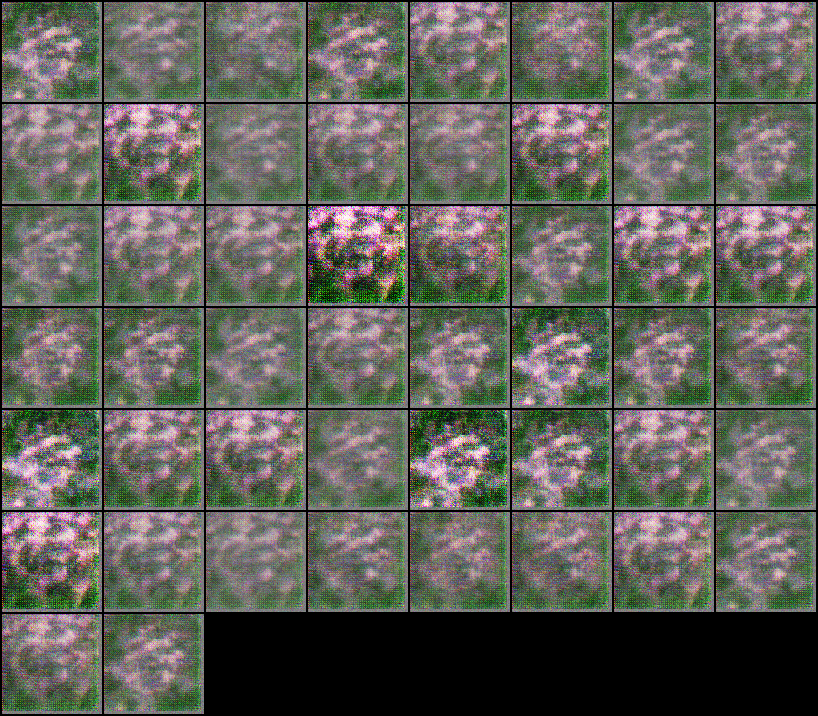

In [48]:
# Generated Images - Epoch 1
Image.open("images/0.png")

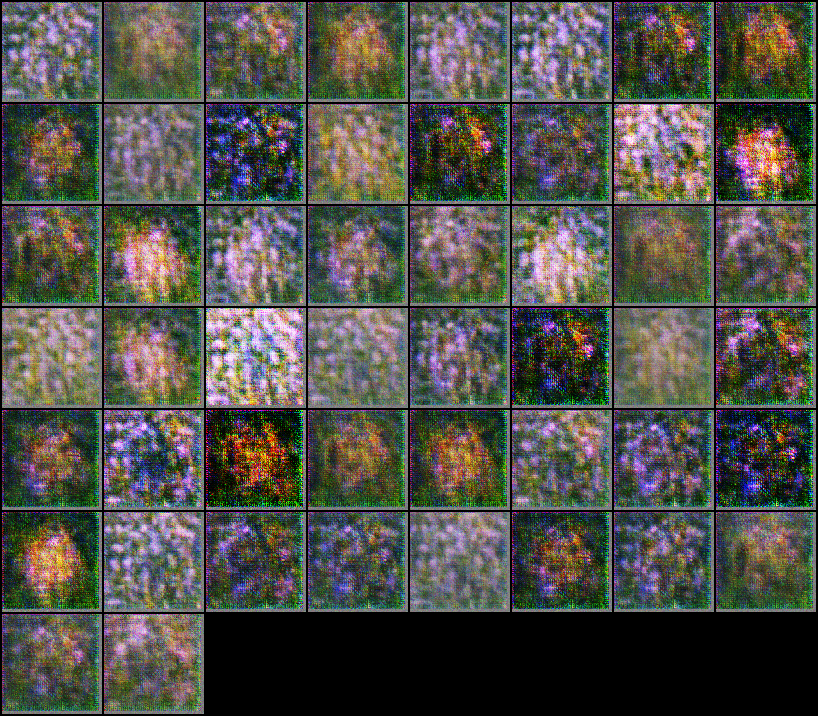

In [49]:
# Generated Images - Epoch 10
Image.open("image/10.png")

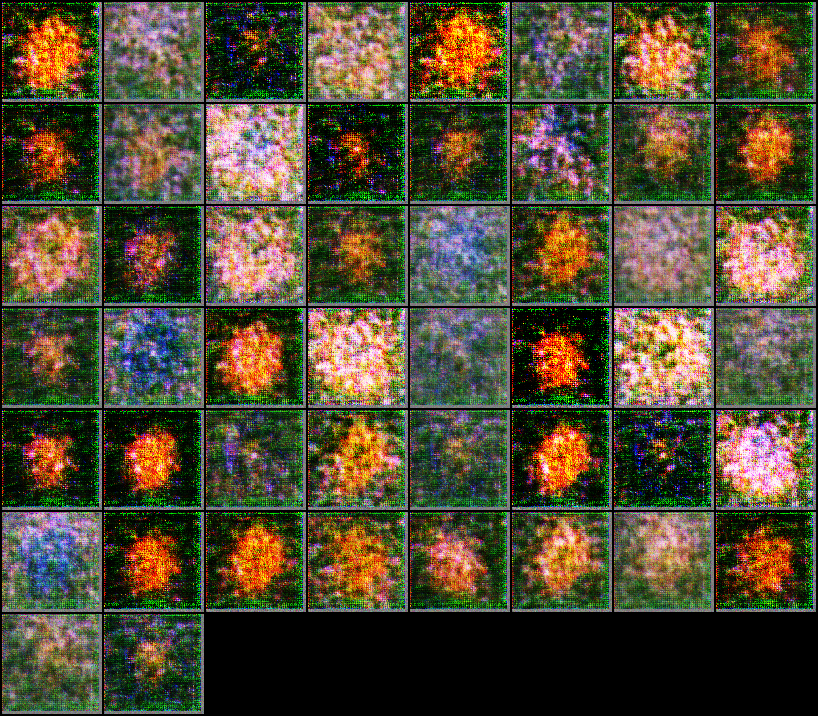

In [50]:
# Generated Images - Epoch 50
Image.open("image/49.png")